In [250]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

In [251]:
data = pd.read_csv('dataframe/champions.csv')

In [252]:
data['Temporada'] = pd.to_datetime(data['Temporada'])

# Ordenar el DataFrame por la columna 'Temporada'
data = data.sort_values(by='Temporada')

In [253]:
from sklearn.model_selection import train_test_split

# Selección de equipos de interés
equipo_de_interes = [1, 3, 5, 14, 16, 24, 28, 31]
equipo_data = data[data['Local'].isin(equipo_de_interes) | data['Visitante'].isin(equipo_de_interes)]

# Concatenar los datos de goles locales y visitantes por partido
serie_temporal_por_equipo = pd.concat([equipo_data.groupby(['Temporada', 'Local']).sum()['GolesLocal'], 
                                       equipo_data.groupby(['Temporada', 'Visitante']).sum()['GolesVisitante']], axis=1)

# Sumar los goles locales y visitantes para obtener el total de goles por partido
serie_temporal_por_equipo['TotalGoles'] = serie_temporal_por_equipo.sum(axis=1)

# División en conjunto de entrenamiento y prueba
train_data, test_data = train_test_split(serie_temporal_por_equipo['TotalGoles'], test_size=0.2, shuffle=False)

# Convertir las fechas a un formato numérico
train_data.index = np.arange(len(train_data))
test_data.index = np.arange(len(train_data), len(train_data) + len(test_data))


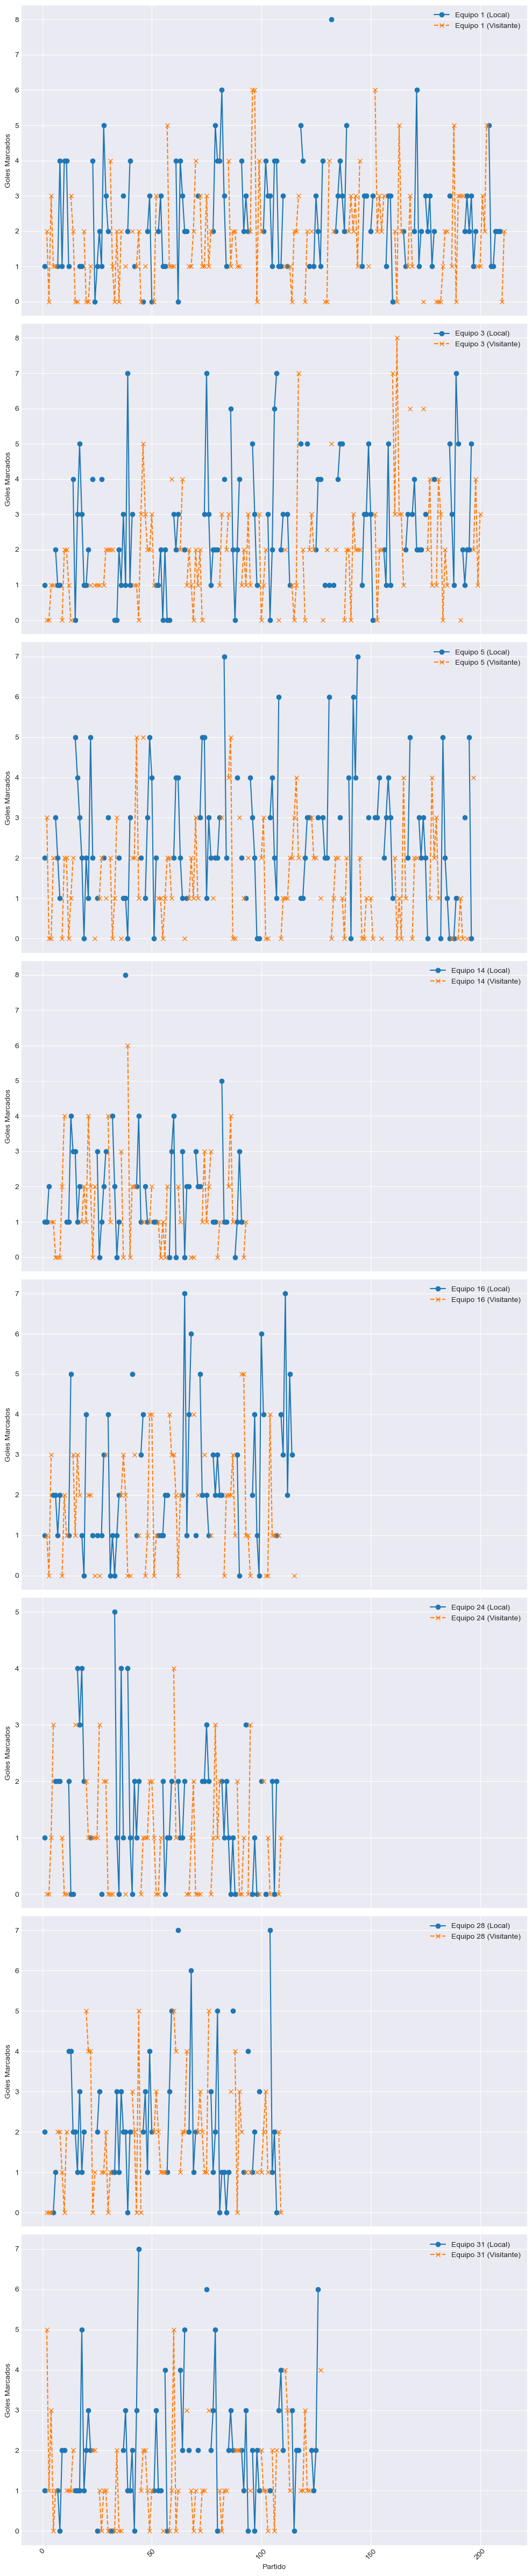

In [254]:
import pandas as pd
import matplotlib.pyplot as plt


# Crear una figura y ejes para trazar
fig, axs = plt.subplots(len(equipo_de_interes), figsize=(10, 6*len(equipo_de_interes)), sharex=True)

# Iterar sobre cada equipo de interés
for i, equipo in enumerate(equipo_de_interes):
    # Filtrar los datos para el equipo local y visitante
    equipo_data_local = data[data['Local'] == equipo][['Temporada', 'GolesLocal']]
    equipo_data_visitante = data[data['Visitante'] == equipo][['Temporada', 'GolesVisitante']]
    
    # Concatenar los datos y ordenar por temporada
    equipo_data = pd.concat([equipo_data_local, equipo_data_visitante])
    equipo_data.sort_values(by='Temporada', inplace=True)
    
    # Convertir la columna 'Temporada' al tipo de datos datetime
    equipo_data['Temporada'] = pd.to_datetime(equipo_data['Temporada'])
    
    # Crear un rango de números para representar los partidos
    partidos = range(1, len(equipo_data) + 1)
    
    # Establecer la columna 'Partido' como el índice del DataFrame
    equipo_data['Partido'] = partidos
    equipo_data.set_index('Partido', inplace=True)
    
    # Graficar la serie temporal de goles para el equipo actual
    axs[i].plot(equipo_data.index, equipo_data['GolesLocal'], marker='o', linestyle='-', label=f'Equipo {equipo} (Local)')
    axs[i].plot(equipo_data.index, equipo_data['GolesVisitante'], marker='x', linestyle='--', label=f'Equipo {equipo} (Visitante)')
    axs[i].set_ylabel('Goles Marcados')
    axs[i].legend()
    axs[i].grid(True)

# Ajustar la apariencia de la figura
plt.xlabel('Partido')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [258]:
def arima_model(train, test, order):
    # Crear el modelo ARIMA
    model = ARIMA(train, order=order)
    
    # Ajustar el modelo a los datos de entrenamiento
    model_fit = model.fit()
    
    # Predecir los valores futuros
    forecast = model_fit.forecast(steps=len(test))
    
    return model_fit, forecast


In [259]:
modelo_arima, forecast = arima_model(train_data, test_data, order=(1, 1, 1))

forecast


365    7.975334
366    7.685883
367    7.644503
368    7.638587
369    7.637741
         ...   
452    7.637600
453    7.637600
454    7.637600
455    7.637600
456    7.637600
Name: predicted_mean, Length: 92, dtype: float64

In [260]:
def evaluacion_modelo(test, forecast):
    errores = test - forecast

    # Métricas de evaluación
    mse = np.mean(errores ** 2)
    mae = np.mean(np.abs(errores))
    rmse = np.sqrt(mse)
    
    # Diccionario con las métricas
    metricas = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }
    
    return metricas

evaluacion_modelo(test_data, forecast)

{'MSE': 72.18510535671142, 'MAE': 6.938126359602138, 'RMSE': 8.496181810478836}